In [1]:
# open a netcdf file, create a time dimension, and assign the new dimension to the variables.
# The script uses xarray
import xarray as xr

In [2]:
#open the netcdf file
ds = xr.open_dataset('subset_all_variables.nc')
ds

<xarray.Dataset> Size: 36MB
Dimensions:         (s_rho: 1, eta_rho: 254, xi_rho: 224, eta_u: 254,
                     xi_u: 223, eta_v: 253, xi_v: 224, ocean_time: 16)
Coordinates:
  * s_rho           (s_rho) float64 8B -0.01389
    lon_rho         (eta_rho, xi_rho) float64 455kB ...
    lat_rho         (eta_rho, xi_rho) float64 455kB ...
    lon_u           (eta_u, xi_u) float64 453kB ...
    lat_u           (eta_u, xi_u) float64 453kB ...
    lon_v           (eta_v, xi_v) float64 453kB ...
    lat_v           (eta_v, xi_v) float64 453kB ...
  * ocean_time      (ocean_time) datetime64[ns] 128B 2023-06-10 ... 2023-06-1...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/13)
    hc              float64 8B ...
    Cs_r            (s_rho) float64 8B ...
    h               (eta_rho, xi_rho) float64 455kB ...
    angle           (eta_rho, xi_rho) float64 455kB ...
    u_rotate        (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB ...
    v_rotate        (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB ...
    ...              ...
    sustr_rotate    (ocean_time, eta_rho, xi_rho) float32 4MB ...
    svstr_rotate    (ocean_time, eta_rho, xi_rho) float32 4MB ...
    sustr           (ocean_time, eta_u, xi_u) float32 4MB ...
    svstr           (ocean_time, eta_v, xi_v) float32 4MB ...
    u               (ocean_time, s_rho, eta_u, xi_u) float32 4MB ...
    v               (ocean_time, s_rho, eta_v, xi_v) float32 4MB ...
Attributes: (12/36)
    file:                       /mnt/lfs4/NOS/nosofs/Yizhen.Li/23forecast/his...
    format:                     netCDF-3 64bit offset file
    Conventions:                CF-1.4
    type:                       ROMS/TOMS history file
    title:                      Gulf of Maine physical-biological model multi...
    rst_file:                   /mnt/lfs4/NOS/nosofs/Yizhen.Li/23forecast/res...
    ...                         ...
    ana_file:                   ROMS/Functionals/ana_btflux.h, ROMS/Functiona...
    bio_file:                   ROMS/Nonlinear/Biology/red_tide.h
    CPP_options:                GOM6, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_B...
    NCO:                        netCDF Operators version 4.7.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    history_of_appended_files:  Thu Nov 14 16:57:46 2024: Appended file cell_...

In [3]:
# plot the dinoflagellate data as a function of ocean_time
ds['dinoflagellate'].head()

<xarray.DataArray 'dinoflagellate' (ocean_time: 5, s_rho: 1, eta_rho: 5,
                                    xi_rho: 5)> Size: 500B
[125 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 8B -0.01389
    lon_rho     (eta_rho, xi_rho) float64 200B ...
    lat_rho     (eta_rho, xi_rho) float64 200B ...
  * ocean_time  (ocean_time) datetime64[ns] 40B 2023-06-10 ... 2023-06-12
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  red tide dinoflagellate concentration
    units:      cell meter-3
    time:       ocean_time
    field:      dinoflagellate, scalar, series

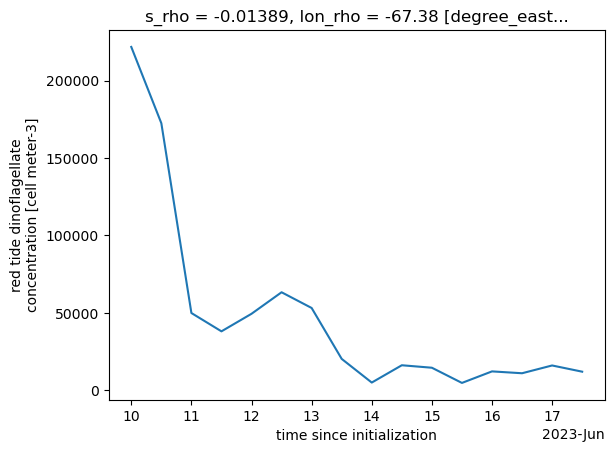

In [4]:
# plot the dinoflagellate data as a function of ocean_time at a specific location
ds['dinoflagellate'].isel(s_rho=0,eta_rho=100,xi_rho=100).plot()

TypeError: Dimensions of C (254, 224) should be one smaller than X(45) and Y(51) while using shading='flat' see help(pcolormesh)

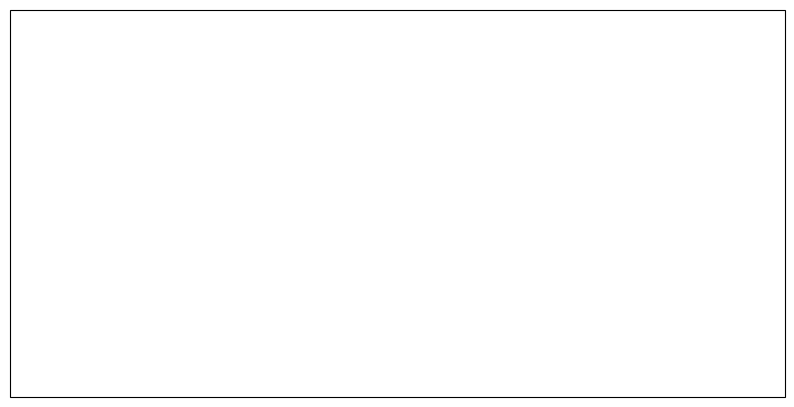

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load ROMS data
data = xr.open_dataset('subset_all_variables.nc')

# Extract variables
u = data['u']  # (ocean_time, s_rho, eta_u, xi_u)
v = data['v']  # (ocean_time, s_rho, eta_v, xi_v)
dinoflagellate = ds["dinoflagellate"]

lon_u = data['lon_u']  # (eta_u, xi_u)
lat_u = data['lat_u']  # (eta_u, xi_u)
lon_v = data['lon_v']  # (eta_v, xi_v)
lat_v = data['lat_v']  # (eta_v, xi_v)

lon_rho = data['lon_rho']  # (eta_rho, xi_rho)
lat_rho = data['lat_rho']  # (eta_rho, xi_rho)

# Select a time and depth slice (e.g., surface at t=0)
u_slice = u.isel(ocean_time=0, s_rho=0)  # Surface layer
v_slice = v.isel(ocean_time=0, s_rho=0)
dino_slice = dinoflagellate.isel(ocean_time=0, s_rho=0)

# Interpolate u to rho grid along xi (longitude)
u_interp = np.empty_like(lon_rho)  # Create an empty array with the same shape as rho grid
for j in range(lon_rho.shape[0]):  # Loop over eta dimension
    u_interp[j, :] = np.interp(
        lon_rho[j, :], lon_u[j, :], u_slice[j, :]
    )

# Interpolate v to rho grid along eta (latitude)
v_interp = np.empty_like(lat_rho)  # Create an empty array with the same shape as rho grid
for i in range(lat_rho.shape[1]):  # Loop over xi dimension
    v_interp[:, i] = np.interp(
        lat_rho[:, i], lat_v[:, i], v_slice[:, i]
    )

# dino_interp = dino_slice.interp(eta_rho=lat_rho, xi_rho=lon_rho)

# downsample the quiver data
step = 5
u_interp = u_interp[::step, ::step] 
v_interp = v_interp[::step, ::step]
# dino_interp = dino_interp[::step, ::step]
lon_rho = lon_rho[::step, ::step] 
lat_rho = lat_rho[::step, ::step]


# Set up the map projection and figure size
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add dinoflagellate as a colormap
mesh = ax.pcolormesh(lon_rho, lat_rho, dino_slice, cmap="viridis", shading="auto", transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", label="Dinoflagellate Concentration")

# Plot quiver
quiver = plt.quiver(lon_rho, lat_rho, u_interp, v_interp, scale=30, pivot="middle", color="blue", transform=ccrs.PlateCarree())

# Add coastlines and other geographic features
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines for better readability
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add labels and title
plt.title("Surface Vector Field (U, V) with Dinoflagellate Concentration")
plt.show()

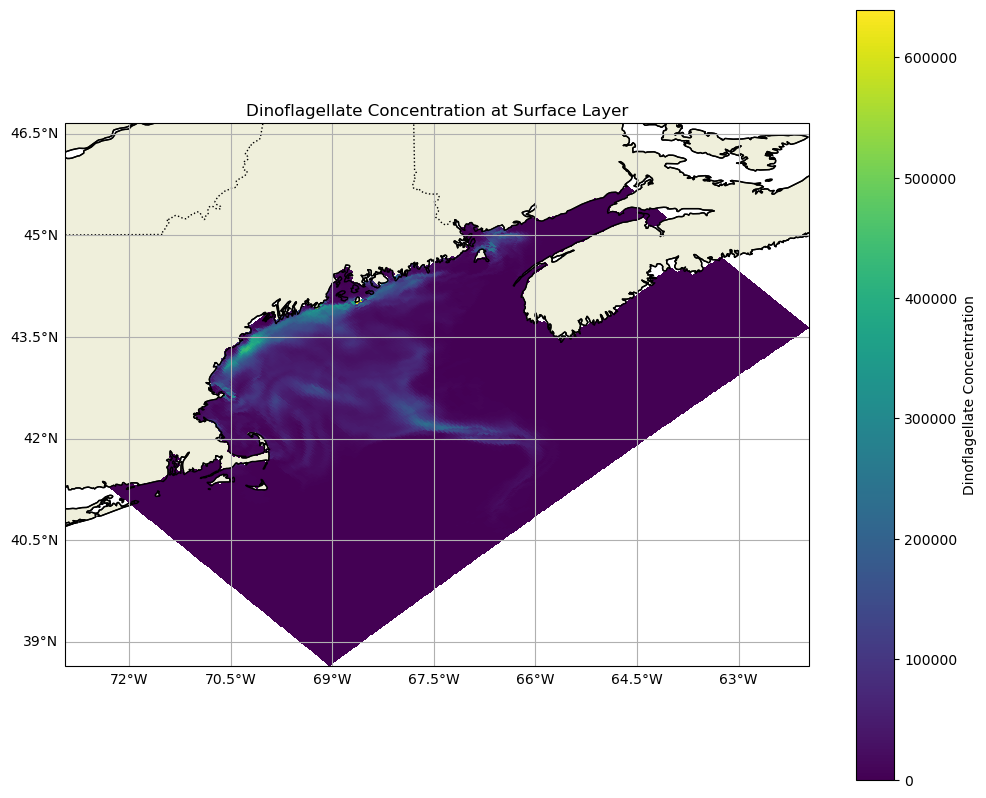

In [14]:
# Extract variables
lon_rho = ds["lon_rho"]
lat_rho = ds["lat_rho"]
dinoflagellate = ds["dinoflagellate"]

# Select a specific time and depth level (adjust indices as needed)
selected_time = 0  # First time step
selected_depth = -1  # Surface layer (first s_rho level)
dinoflagellate_slice = dinoflagellate.isel(ocean_time=selected_time, s_rho=selected_depth)

# Plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add dinoflagellate as a colormap
mesh = ax.pcolormesh(
    lon_rho,
    lat_rho,
    dinoflagellate_slice,
    cmap="viridis",
    shading="auto",
    transform=ccrs.PlateCarree(),
)

# Add coastlines and geographic features
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", label="Dinoflagellate Concentration")

# Add gridlines and title
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Dinoflagellate Concentration at Surface Layer")
plt.show()

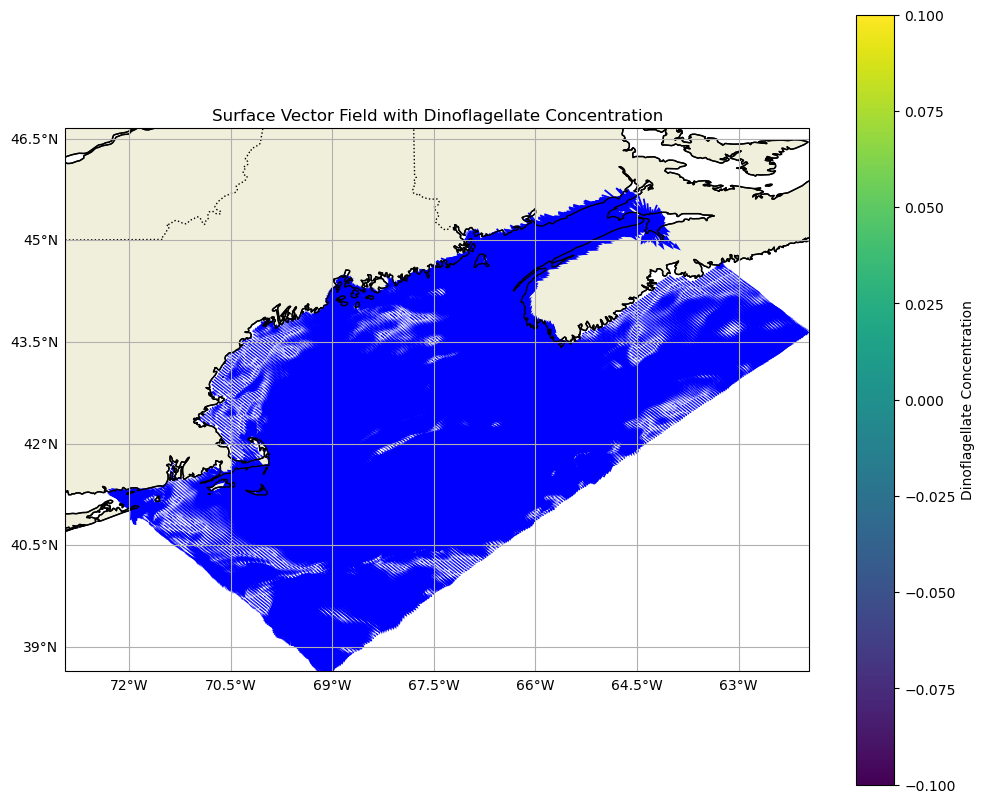

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the ROMS NetCDF file
ds = xr.open_dataset("subset_all_variables.nc")

# Extract variables
lon_rho = ds["lon_rho"]
lat_rho = ds["lat_rho"]
u = ds["u"].isel(ocean_time=0, s_rho=0)
v = ds["v"].isel(ocean_time=0, s_rho=0)
dinoflagellate = ds["dinoflagellate"].isel(ocean_time=0, s_rho=0)

# Interpolate u to rho grid along xi (longitude)
u_interp = np.empty_like(lon_rho)  # Create an empty array with the same shape as rho grid
for j in range(lon_rho.shape[0]):  # Loop over eta dimension
    u_interp[j, :] = np.interp(
        lon_rho[j, :], lon_u[j, :], u_slice[j, :]
    )

# Interpolate v to rho grid along eta (latitude)
v_interp = np.empty_like(lat_rho)  # Create an empty array with the same shape as rho grid
for i in range(lat_rho.shape[1]):  # Loop over xi dimension
    v_interp[:, i] = np.interp(
        lat_rho[:, i], lat_v[:, i], v_slice[:, i]
    )

# downsample the quiver data
step = 5
u_interp = u_interp[::step, ::step] 
v_interp = v_interp[::step, ::step]
# dino_interp = dino_interp[::step, ::step]
lon_rho = lon_rho[::step, ::step] 
lat_rho = lat_rho[::step, ::step]

# Interpolate dinoflagellate to the same grid as lon_rho and lat_rho
dinoflagellate_interp = dinoflagellate.interp(eta_rho=lat_rho, xi_rho=lon_rho)

# Plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Ensure lon_rho and lat_rho align with dinoflagellate dimensions
mesh = ax.pcolormesh(
    lon_rho, lat_rho, dinoflagellate_interp, cmap="viridis", shading="auto", transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", label="Dinoflagellate Concentration")

# Add quiver plot
quiver = plt.quiver(
    lon_rho, lat_rho, u_interp, v_interp, scale=30, pivot="middle", color="blue", transform=ccrs.PlateCarree()
)

# Add coastlines and geographic features
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Surface Vector Field with Dinoflagellate Concentration")
plt.show()
